# IMDB-WIKI
##  Multi-task age and gender classification

On the original paper [DEX: Deep EXpectation of apparent age from a single image](https://www.vision.ee.ethz.ch/en/publications/papers/proceedings/eth_biwi_01229.pdf) the authors were able to display remarkable results in classifying the age of an individual based on a given image alone. 

Let see how accuracy (bad I guess), with limited resources, we can get with self-construct architecture. And not only age, we also classifying gender by using multi-task training technique.

In [10]:
import os
from six.moves import cPickle as pickle
import numpy as np
import scipy.io as sio
import scipy.misc as spm
from scipy import ndimage
import datetime
import matplotlib.image as plt
from IPython.display import Image, display
from skimage.transform import resize
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

IMG_DIR = r'/Users/truongnm/coding/cnn/datasets/imdb_crop'
MAT_FILE = r'/Users/truongnm/coding/cnn/datasets/imdb_crop/imdb.mat'

img_depth = 1
img_size = 128
num_classes = 2

max_bytes = 2**31 - 1

First, the labels, which was not easily obtained. The meta data is stored separately and in a .mat file. (Yes, matlab)!

The age parameter, requires us to calculate by taking the ```photo_taken``` and subtracting the ```dob```, the date of birth. Sounds easy? No ... as the dob is stored as a Matlab serial number.

Luckily we can use the ```scipy.io.loadmat``` to load the ```.mat``` file to python accessible (kind of) format. We can access the ```dob``` by some proper indexing, and convert the Matlab serial number to a usable format by using ```datetime.date.fromordinal( serial_number ).year```.

In [5]:
def reformat_date(mat_date):
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

In [6]:
def create_path(path):
    return os.path.join(IMG_DIR, path[0])

In [11]:
mat_struct = sio.loadmat(MAT_FILE)
data_set = [data[0] for data in mat_struct['imdb'][0, 0]]

keys = ['dob',
    'photo_taken',
    'full_path',
    'gender',
    'name',
    'face_location',
    'face_score',
    'second_face_score',
    'celeb_names',
    'celeb_id'
]

imdb_dict = dict(zip(keys, np.asarray(data_set)))
imdb_dict['dob'] = [reformat_date(dob) for dob in imdb_dict['dob']]
imdb_dict['full_path'] = [create_path(path) for path in imdb_dict['full_path']]

# Add 'age' key to the dictionary
imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

print("Dictionary created...")

Dictionary created...


The IMDB dataset has total 460,723 face images from 20,284 celebrities. 

We will ignore:
* images with more than one face
* gender is NaN
* invalid age.

In [29]:
raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_sface = imdb_dict['second_face_score']

age = []
gender = []
imgs = []
current_age = {0:0, 1:0, 2:0, 3:0}
for i, sface in enumerate(raw_sface):
    if i%50000==0:
        print("Processing {0} of {1}".format(i,len(raw_sface)))
#         display(Image(filename=raw_path[i]))
        print("Second face score: {}".format(sface))
        print("Age: {}".format(raw_age[i]))
        print("Gender: {}".format(raw_gender[i]))
    if np.isnan(sface) and raw_age[i] >= 0 and not np.isnan(raw_gender[i]):
        age_tmp = 0;
        if len(age) == 170000:
            break
        if raw_age[i] < 30 and current_age[0] < 42500:
            current_age[0] += 1
            age_tmp = 0
        elif raw_age[i] <= 45 and current_age[1] < 69923:
            current_age[1] += 1
            age_tmp = 1
        elif raw_age[i] < 60 and current_age[2] < 42500:
            current_age[2] += 1
            age_tmp = 2
        elif raw_age[i] >= 60 and current_age[3] < 42500:
            current_age[3] += 1
            age_tmp = 3
        else:
            print("Weired   I: {0} - Age: {1}".format(i,raw_age[i]))
            continue
        age.append(age_tmp)
        gender.append(raw_gender[i])
        imgs.append(raw_path[i])

Processing 0 of 460723
Second face score: 1.11897335716
Age: 69
Gender: 1.0
Processing 50000 of 460723
Second face score: 1.63826037844
Age: 62
Gender: 1.0
Processing 100000 of 460723
Second face score: nan
Age: 48
Gender: 1.0
Processing 150000 of 460723
Second face score: nan
Age: 45
Gender: 0.0
Processing 200000 of 460723
Second face score: nan
Age: 55
Gender: 1.0
Processing 250000 of 460723
Second face score: 3.75576455544
Age: 35
Gender: 1.0
Processing 300000 of 460723
Second face score: 1.44904310535
Age: 27
Gender: 0.0
Weired   I: 320453 - Age: 20
Weired   I: 320454 - Age: 18
Weired   I: 320456 - Age: 19
Weired   I: 320457 - Age: 19
Weired   I: 320458 - Age: 19
Weired   I: 320459 - Age: 12
Weired   I: 320460 - Age: 12
Weired   I: 320461 - Age: 12
Weired   I: 320464 - Age: 12
Weired   I: 320465 - Age: 12
Weired   I: 320466 - Age: 22
Weired   I: 320470 - Age: 30
Weired   I: 320471 - Age: 27
Weired   I: 320472 - Age: 28
Weired   I: 320473 - Age: 28
Weired   I: 320474 - Age: 24
Weire

Weired   I: 322485 - Age: 39
Weired   I: 322486 - Age: 42
Weired   I: 322488 - Age: 34
Weired   I: 322489 - Age: 29
Weired   I: 322493 - Age: 39
Weired   I: 322495 - Age: 42
Weired   I: 322500 - Age: 42
Weired   I: 322502 - Age: 43
Weired   I: 322504 - Age: 29
Weired   I: 322506 - Age: 35
Weired   I: 322509 - Age: 39
Weired   I: 322511 - Age: 29
Weired   I: 322514 - Age: 38
Weired   I: 322515 - Age: 38
Weired   I: 322523 - Age: 32
Weired   I: 322530 - Age: 41
Weired   I: 322535 - Age: 32
Weired   I: 322537 - Age: 25
Weired   I: 322540 - Age: 44
Weired   I: 322541 - Age: 38
Weired   I: 322543 - Age: 29
Weired   I: 322546 - Age: 39
Weired   I: 322548 - Age: 29
Weired   I: 322550 - Age: 46
Weired   I: 322555 - Age: 29
Weired   I: 322560 - Age: 40
Weired   I: 322561 - Age: 42
Weired   I: 322563 - Age: 39
Weired   I: 322565 - Age: 39
Weired   I: 322571 - Age: 45
Weired   I: 322574 - Age: 46
Weired   I: 322575 - Age: 43
Weired   I: 322576 - Age: 44
Weired   I: 322578 - Age: 46
Weired   I: 32

Weired   I: 324872 - Age: 25
Weired   I: 324873 - Age: 25
Weired   I: 324875 - Age: 25
Weired   I: 324876 - Age: 25
Weired   I: 324877 - Age: 25
Weired   I: 324878 - Age: 25
Weired   I: 324879 - Age: 25
Weired   I: 324880 - Age: 25
Weired   I: 324881 - Age: 25
Weired   I: 324882 - Age: 25
Weired   I: 324883 - Age: 25
Weired   I: 324884 - Age: 25
Weired   I: 324885 - Age: 25
Weired   I: 324887 - Age: 25
Weired   I: 324889 - Age: 25
Weired   I: 324891 - Age: 25
Weired   I: 324892 - Age: 25
Weired   I: 324893 - Age: 25
Weired   I: 324894 - Age: 25
Weired   I: 324895 - Age: 25
Weired   I: 324896 - Age: 25
Weired   I: 324897 - Age: 25
Weired   I: 324898 - Age: 25
Weired   I: 324900 - Age: 25
Weired   I: 324903 - Age: 25
Weired   I: 324905 - Age: 25
Weired   I: 324906 - Age: 25
Weired   I: 324907 - Age: 25
Weired   I: 324909 - Age: 30
Weired   I: 324910 - Age: 30
Weired   I: 324912 - Age: 30
Weired   I: 324914 - Age: 25
Weired   I: 324915 - Age: 25
Weired   I: 324918 - Age: 25
Weired   I: 32

Weired   I: 326993 - Age: 41
Weired   I: 326995 - Age: 41
Weired   I: 326996 - Age: 39
Weired   I: 326997 - Age: 39
Weired   I: 327003 - Age: 50
Weired   I: 327005 - Age: 50
Weired   I: 327006 - Age: 47
Weired   I: 327007 - Age: 47
Weired   I: 327008 - Age: 47
Weired   I: 327013 - Age: 39
Weired   I: 327014 - Age: 33
Weired   I: 327015 - Age: 33
Weired   I: 327016 - Age: 33
Weired   I: 327017 - Age: 33
Weired   I: 327018 - Age: 33
Weired   I: 327019 - Age: 34
Weired   I: 327020 - Age: 34
Weired   I: 327024 - Age: 12
Weired   I: 327025 - Age: 53
Weired   I: 327031 - Age: 27
Weired   I: 327034 - Age: 49
Weired   I: 327037 - Age: 55
Weired   I: 327041 - Age: 27
Weired   I: 327042 - Age: 28
Weired   I: 327043 - Age: 28
Weired   I: 327044 - Age: 28
Weired   I: 327046 - Age: 29
Weired   I: 327047 - Age: 29
Weired   I: 327048 - Age: 29
Weired   I: 327049 - Age: 27
Weired   I: 327051 - Age: 37
Weired   I: 327053 - Age: 34
Weired   I: 327055 - Age: 33
Weired   I: 327056 - Age: 28
Weired   I: 32

Weired   I: 329296 - Age: 35
Weired   I: 329297 - Age: 38
Weired   I: 329298 - Age: 35
Weired   I: 329299 - Age: 38
Weired   I: 329300 - Age: 35
Weired   I: 329301 - Age: 38
Weired   I: 329302 - Age: 35
Weired   I: 329303 - Age: 38
Weired   I: 329304 - Age: 35
Weired   I: 329305 - Age: 41
Weired   I: 329306 - Age: 35
Weired   I: 329308 - Age: 35
Weired   I: 329309 - Age: 35
Weired   I: 329312 - Age: 35
Weired   I: 329313 - Age: 35
Weired   I: 329314 - Age: 41
Weired   I: 329317 - Age: 41
Weired   I: 329319 - Age: 41
Weired   I: 329320 - Age: 36
Weired   I: 329321 - Age: 36
Weired   I: 329322 - Age: 41
Weired   I: 329328 - Age: 35
Weired   I: 329329 - Age: 41
Weired   I: 329330 - Age: 22
Weired   I: 329331 - Age: 41
Weired   I: 329334 - Age: 41
Weired   I: 329336 - Age: 41
Weired   I: 329338 - Age: 30
Weired   I: 329340 - Age: 35
Weired   I: 329343 - Age: 41
Weired   I: 329344 - Age: 53
Weired   I: 329345 - Age: 53
Weired   I: 329346 - Age: 53
Weired   I: 329347 - Age: 50
Weired   I: 32

Weired   I: 332017 - Age: 30
Weired   I: 332018 - Age: 30
Weired   I: 332019 - Age: 30
Weired   I: 332020 - Age: 30
Weired   I: 332021 - Age: 43
Weired   I: 332023 - Age: 30
Weired   I: 332024 - Age: 30
Weired   I: 332027 - Age: 30
Weired   I: 332028 - Age: 30
Weired   I: 332029 - Age: 51
Weired   I: 332035 - Age: 36
Weired   I: 332036 - Age: 36
Weired   I: 332037 - Age: 36
Weired   I: 332038 - Age: 36
Weired   I: 332039 - Age: 36
Weired   I: 332040 - Age: 36
Weired   I: 332045 - Age: 36
Weired   I: 332047 - Age: 36
Weired   I: 332049 - Age: 42
Weired   I: 332050 - Age: 38
Weired   I: 332053 - Age: 45
Weired   I: 332062 - Age: 33
Weired   I: 332063 - Age: 33
Weired   I: 332064 - Age: 33
Weired   I: 332065 - Age: 33
Weired   I: 332066 - Age: 33
Weired   I: 332067 - Age: 39
Weired   I: 332068 - Age: 41
Weired   I: 332069 - Age: 41
Weired   I: 332070 - Age: 39
Weired   I: 332071 - Age: 39
Weired   I: 332072 - Age: 42
Weired   I: 332073 - Age: 42
Weired   I: 332074 - Age: 39
Weired   I: 33

Weired   I: 333744 - Age: 34
Weired   I: 333745 - Age: 31
Weired   I: 333747 - Age: 38
Weired   I: 333748 - Age: 38
Weired   I: 333749 - Age: 34
Weired   I: 333750 - Age: 38
Weired   I: 333751 - Age: 34
Weired   I: 333752 - Age: 33
Weired   I: 333753 - Age: 31
Weired   I: 333754 - Age: 35
Weired   I: 333757 - Age: 31
Weired   I: 333758 - Age: 38
Weired   I: 333760 - Age: 37
Weired   I: 333763 - Age: 32
Weired   I: 333766 - Age: 38
Weired   I: 333768 - Age: 39
Weired   I: 333771 - Age: 29
Weired   I: 333772 - Age: 32
Weired   I: 333773 - Age: 29
Weired   I: 333776 - Age: 32
Weired   I: 333779 - Age: 35
Weired   I: 333780 - Age: 30
Weired   I: 333781 - Age: 30
Weired   I: 333785 - Age: 33
Weired   I: 333786 - Age: 33
Weired   I: 333787 - Age: 29
Weired   I: 333788 - Age: 33
Weired   I: 333789 - Age: 29
Weired   I: 333790 - Age: 34
Weired   I: 333791 - Age: 35
Weired   I: 333792 - Age: 39
Weired   I: 333793 - Age: 31
Weired   I: 333794 - Age: 31
Weired   I: 333795 - Age: 31
Weired   I: 33

Weired   I: 336217 - Age: 39
Weired   I: 336219 - Age: 46
Weired   I: 336221 - Age: 51
Weired   I: 336222 - Age: 55
Weired   I: 336223 - Age: 55
Weired   I: 336224 - Age: 51
Weired   I: 336226 - Age: 44
Weired   I: 336228 - Age: 44
Weired   I: 336230 - Age: 57
Weired   I: 336231 - Age: 52
Weired   I: 336232 - Age: 59
Weired   I: 336236 - Age: 44
Weired   I: 336237 - Age: 44
Weired   I: 336239 - Age: 41
Weired   I: 336240 - Age: 35
Weired   I: 336245 - Age: 55
Weired   I: 336246 - Age: 55
Weired   I: 336247 - Age: 30
Weired   I: 336248 - Age: 30
Weired   I: 336249 - Age: 30
Weired   I: 336252 - Age: 15
Weired   I: 336253 - Age: 18
Weired   I: 336257 - Age: 59
Weired   I: 336258 - Age: 58
Weired   I: 336259 - Age: 58
Weired   I: 336262 - Age: 58
Weired   I: 336263 - Age: 58
Weired   I: 336264 - Age: 39
Weired   I: 336265 - Age: 38
Weired   I: 336266 - Age: 38
Weired   I: 336271 - Age: 40
Weired   I: 336276 - Age: 35
Weired   I: 336278 - Age: 35
Weired   I: 336281 - Age: 35
Weired   I: 33

Weired   I: 339210 - Age: 54
Weired   I: 339211 - Age: 40
Weired   I: 339212 - Age: 40
Weired   I: 339222 - Age: 38
Weired   I: 339223 - Age: 37
Weired   I: 339225 - Age: 38
Weired   I: 339227 - Age: 38
Weired   I: 339228 - Age: 37
Weired   I: 339229 - Age: 37
Weired   I: 339230 - Age: 38
Weired   I: 339234 - Age: 38
Weired   I: 339239 - Age: 39
Weired   I: 339240 - Age: 59
Weired   I: 339241 - Age: 59
Weired   I: 339248 - Age: 34
Weired   I: 339259 - Age: 33
Weired   I: 339260 - Age: 33
Weired   I: 339261 - Age: 33
Weired   I: 339262 - Age: 33
Weired   I: 339265 - Age: 33
Weired   I: 339266 - Age: 33
Weired   I: 339269 - Age: 33
Weired   I: 339270 - Age: 33
Weired   I: 339276 - Age: 33
Weired   I: 339277 - Age: 33
Weired   I: 339278 - Age: 33
Weired   I: 339279 - Age: 53
Weired   I: 339282 - Age: 43
Weired   I: 339283 - Age: 43
Weired   I: 339284 - Age: 38
Weired   I: 339286 - Age: 40
Weired   I: 339287 - Age: 40
Weired   I: 339288 - Age: 40
Weired   I: 339289 - Age: 24
Weired   I: 33

Weired   I: 342123 - Age: 32
Weired   I: 342124 - Age: 25
Weired   I: 342125 - Age: 33
Weired   I: 342127 - Age: 33
Weired   I: 342128 - Age: 33
Weired   I: 342129 - Age: 33
Weired   I: 342130 - Age: 33
Weired   I: 342131 - Age: 26
Weired   I: 342132 - Age: 26
Weired   I: 342133 - Age: 26
Weired   I: 342134 - Age: 29
Weired   I: 342135 - Age: 29
Weired   I: 342138 - Age: 25
Weired   I: 342140 - Age: 32
Weired   I: 342142 - Age: 27
Weired   I: 342143 - Age: 34
Weired   I: 342145 - Age: 27
Weired   I: 342146 - Age: 27
Weired   I: 342148 - Age: 34
Weired   I: 342149 - Age: 41
Weired   I: 342150 - Age: 31
Weired   I: 342151 - Age: 35
Weired   I: 342152 - Age: 35
Weired   I: 342154 - Age: 37
Weired   I: 342157 - Age: 39
Weired   I: 342158 - Age: 28
Weired   I: 342159 - Age: 39
Weired   I: 342162 - Age: 39
Weired   I: 342163 - Age: 39
Weired   I: 342165 - Age: 39
Weired   I: 342168 - Age: 36
Weired   I: 342170 - Age: 29
Weired   I: 342175 - Age: 29
Weired   I: 342177 - Age: 29
Weired   I: 34

Weired   I: 344326 - Age: 45
Weired   I: 344327 - Age: 45
Weired   I: 344329 - Age: 45
Weired   I: 344330 - Age: 21
Weired   I: 344331 - Age: 21
Weired   I: 344334 - Age: 45
Weired   I: 344335 - Age: 45
Weired   I: 344337 - Age: 45
Weired   I: 344338 - Age: 40
Weired   I: 344339 - Age: 21
Weired   I: 344341 - Age: 45
Weired   I: 344342 - Age: 45
Weired   I: 344343 - Age: 45
Weired   I: 344345 - Age: 45
Weired   I: 344346 - Age: 45
Weired   I: 344347 - Age: 45
Weired   I: 344348 - Age: 45
Weired   I: 344352 - Age: 45
Weired   I: 344353 - Age: 45
Weired   I: 344354 - Age: 45
Weired   I: 344355 - Age: 45
Weired   I: 344356 - Age: 40
Weired   I: 344358 - Age: 45
Weired   I: 344359 - Age: 44
Weired   I: 344362 - Age: 44
Weired   I: 344363 - Age: 45
Weired   I: 344364 - Age: 44
Weired   I: 344365 - Age: 44
Weired   I: 344366 - Age: 45
Weired   I: 344370 - Age: 36
Weired   I: 344371 - Age: 40
Weired   I: 344372 - Age: 45
Weired   I: 344374 - Age: 45
Weired   I: 344377 - Age: 45
Weired   I: 34

Weired   I: 346854 - Age: 42
Weired   I: 346855 - Age: 37
Weired   I: 346857 - Age: 35
Weired   I: 346858 - Age: 35
Weired   I: 346859 - Age: 35
Weired   I: 346860 - Age: 35
Weired   I: 346861 - Age: 35
Weired   I: 346862 - Age: 35
Weired   I: 346866 - Age: 35
Weired   I: 346867 - Age: 35
Weired   I: 346868 - Age: 35
Weired   I: 346872 - Age: 35
Weired   I: 346874 - Age: 35
Weired   I: 346876 - Age: 35
Weired   I: 346884 - Age: 35
Weired   I: 346885 - Age: 35
Weired   I: 346886 - Age: 36
Weired   I: 346887 - Age: 35
Weired   I: 346888 - Age: 34
Weired   I: 346889 - Age: 34
Weired   I: 346890 - Age: 34
Weired   I: 346891 - Age: 34
Weired   I: 346892 - Age: 35
Weired   I: 346893 - Age: 35
Weired   I: 346894 - Age: 35
Weired   I: 346895 - Age: 35
Weired   I: 346896 - Age: 35
Weired   I: 346897 - Age: 35
Weired   I: 346898 - Age: 35
Weired   I: 346899 - Age: 35
Weired   I: 346901 - Age: 34
Weired   I: 346902 - Age: 34
Weired   I: 346903 - Age: 46
Weired   I: 346906 - Age: 42
Weired   I: 34

Weired   I: 349265 - Age: 35
Weired   I: 349267 - Age: 37
Weired   I: 349269 - Age: 37
Weired   I: 349270 - Age: 37
Weired   I: 349271 - Age: 37
Weired   I: 349272 - Age: 43
Weired   I: 349273 - Age: 37
Weired   I: 349274 - Age: 37
Weired   I: 349276 - Age: 37
Weired   I: 349277 - Age: 43
Weired   I: 349278 - Age: 37
Weired   I: 349286 - Age: 37
Weired   I: 349287 - Age: 37
Weired   I: 349288 - Age: 43
Weired   I: 349294 - Age: 31
Weired   I: 349297 - Age: 31
Weired   I: 349300 - Age: 31
Weired   I: 349304 - Age: 49
Weired   I: 349309 - Age: 49
Weired   I: 349315 - Age: 38
Weired   I: 349316 - Age: 57
Weired   I: 349321 - Age: 38
Weired   I: 349323 - Age: 43
Weired   I: 349324 - Age: 42
Weired   I: 349325 - Age: 43
Weired   I: 349326 - Age: 43
Weired   I: 349327 - Age: 42
Weired   I: 349328 - Age: 41
Weired   I: 349329 - Age: 41
Weired   I: 349330 - Age: 41
Weired   I: 349331 - Age: 39
Weired   I: 349332 - Age: 41
Weired   I: 349333 - Age: 43
Weired   I: 349334 - Age: 33
Weired   I: 34

Weired   I: 351747 - Age: 39
Weired   I: 351749 - Age: 39
Weired   I: 351750 - Age: 27
Weired   I: 351751 - Age: 28
Weired   I: 351753 - Age: 27
Weired   I: 351754 - Age: 27
Weired   I: 351756 - Age: 27
Weired   I: 351757 - Age: 27
Weired   I: 351758 - Age: 27
Weired   I: 351759 - Age: 27
Weired   I: 351762 - Age: 27
Weired   I: 351763 - Age: 27
Weired   I: 351764 - Age: 27
Weired   I: 351767 - Age: 27
Weired   I: 351768 - Age: 27
Weired   I: 351769 - Age: 27
Weired   I: 351771 - Age: 27
Weired   I: 351773 - Age: 27
Weired   I: 351774 - Age: 27
Weired   I: 351775 - Age: 29
Weired   I: 351776 - Age: 27
Weired   I: 351777 - Age: 27
Weired   I: 351778 - Age: 27
Weired   I: 351779 - Age: 27
Weired   I: 351780 - Age: 27
Weired   I: 351782 - Age: 27
Weired   I: 351784 - Age: 27
Weired   I: 351788 - Age: 29
Weired   I: 351789 - Age: 27
Weired   I: 351790 - Age: 27
Weired   I: 351793 - Age: 27
Weired   I: 351796 - Age: 27
Weired   I: 351797 - Age: 27
Weired   I: 351798 - Age: 27
Weired   I: 35

Weired   I: 354276 - Age: 31
Weired   I: 354277 - Age: 31
Weired   I: 354278 - Age: 31
Weired   I: 354279 - Age: 31
Weired   I: 354280 - Age: 31
Weired   I: 354281 - Age: 31
Weired   I: 354282 - Age: 31
Weired   I: 354283 - Age: 31
Weired   I: 354284 - Age: 31
Weired   I: 354285 - Age: 31
Weired   I: 354286 - Age: 31
Weired   I: 354287 - Age: 31
Weired   I: 354288 - Age: 33
Weired   I: 354289 - Age: 31
Weired   I: 354290 - Age: 31
Weired   I: 354292 - Age: 31
Weired   I: 354293 - Age: 31
Weired   I: 354295 - Age: 31
Weired   I: 354296 - Age: 31
Weired   I: 354297 - Age: 31
Weired   I: 354299 - Age: 31
Weired   I: 354301 - Age: 32
Weired   I: 354302 - Age: 31
Weired   I: 354303 - Age: 26
Weired   I: 354304 - Age: 31
Weired   I: 354305 - Age: 26
Weired   I: 354306 - Age: 31
Weired   I: 354307 - Age: 31
Weired   I: 354308 - Age: 31
Weired   I: 354309 - Age: 31
Weired   I: 354310 - Age: 31
Weired   I: 354311 - Age: 31
Weired   I: 354312 - Age: 31
Weired   I: 354315 - Age: 31
Weired   I: 35

Weired   I: 356274 - Age: 30
Weired   I: 356275 - Age: 31
Weired   I: 356276 - Age: 33
Weired   I: 356278 - Age: 33
Weired   I: 356279 - Age: 33
Weired   I: 356280 - Age: 30
Weired   I: 356281 - Age: 30
Weired   I: 356283 - Age: 30
Weired   I: 356284 - Age: 30
Weired   I: 356286 - Age: 30
Weired   I: 356287 - Age: 33
Weired   I: 356288 - Age: 33
Weired   I: 356292 - Age: 23
Weired   I: 356293 - Age: 23
Weired   I: 356294 - Age: 23
Weired   I: 356295 - Age: 27
Weired   I: 356297 - Age: 23
Weired   I: 356300 - Age: 23
Weired   I: 356301 - Age: 25
Weired   I: 356302 - Age: 25
Weired   I: 356306 - Age: 27
Weired   I: 356307 - Age: 27
Weired   I: 356308 - Age: 27
Weired   I: 356310 - Age: 26
Weired   I: 356313 - Age: 24
Weired   I: 356315 - Age: 26
Weired   I: 356318 - Age: 27
Weired   I: 356319 - Age: 27
Weired   I: 356320 - Age: 27
Weired   I: 356322 - Age: 30
Weired   I: 356328 - Age: 27
Weired   I: 356329 - Age: 29
Weired   I: 356332 - Age: 29
Weired   I: 356333 - Age: 27
Weired   I: 35

Weired   I: 359116 - Age: 22
Weired   I: 359117 - Age: 30
Weired   I: 359118 - Age: 22
Weired   I: 359119 - Age: 22
Weired   I: 359120 - Age: 22
Weired   I: 359122 - Age: 22
Weired   I: 359123 - Age: 22
Weired   I: 359125 - Age: 23
Weired   I: 359127 - Age: 22
Weired   I: 359128 - Age: 22
Weired   I: 359130 - Age: 30
Weired   I: 359135 - Age: 22
Weired   I: 359139 - Age: 30
Weired   I: 359140 - Age: 22
Weired   I: 359141 - Age: 25
Weired   I: 359142 - Age: 22
Weired   I: 359144 - Age: 21
Weired   I: 359148 - Age: 22
Weired   I: 359149 - Age: 21
Weired   I: 359150 - Age: 22
Weired   I: 359152 - Age: 22
Weired   I: 359162 - Age: 25
Weired   I: 359163 - Age: 22
Weired   I: 359165 - Age: 22
Weired   I: 359166 - Age: 25
Weired   I: 359167 - Age: 22
Weired   I: 359169 - Age: 24
Weired   I: 359175 - Age: 25
Weired   I: 359176 - Age: 22
Weired   I: 359177 - Age: 22
Weired   I: 359179 - Age: 22
Weired   I: 359183 - Age: 22
Weired   I: 359191 - Age: 22
Weired   I: 359192 - Age: 22
Weired   I: 35

Weired   I: 360838 - Age: 40
Weired   I: 360839 - Age: 40
Weired   I: 360842 - Age: 40
Weired   I: 360843 - Age: 40
Weired   I: 360845 - Age: 32
Weired   I: 360847 - Age: 27
Weired   I: 360849 - Age: 24
Weired   I: 360850 - Age: 31
Weired   I: 360856 - Age: 34
Weired   I: 360858 - Age: 31
Weired   I: 360866 - Age: 29
Weired   I: 360870 - Age: 28
Weired   I: 360871 - Age: 28
Weired   I: 360873 - Age: 35
Weired   I: 360876 - Age: 28
Weired   I: 360877 - Age: 30
Weired   I: 360878 - Age: 30
Weired   I: 360879 - Age: 30
Weired   I: 360881 - Age: 40
Weired   I: 360882 - Age: 40
Weired   I: 360883 - Age: 40
Weired   I: 360884 - Age: 40
Weired   I: 360886 - Age: 37
Weired   I: 360887 - Age: 37
Weired   I: 360888 - Age: 37
Weired   I: 360890 - Age: 37
Weired   I: 360892 - Age: 37
Weired   I: 360893 - Age: 37
Weired   I: 360894 - Age: 37
Weired   I: 360895 - Age: 37
Weired   I: 360903 - Age: 15
Weired   I: 360904 - Age: 15
Weired   I: 360906 - Age: 35
Weired   I: 360911 - Age: 39
Weired   I: 36

Weired   I: 364060 - Age: 34
Weired   I: 364061 - Age: 31
Weired   I: 364063 - Age: 34
Weired   I: 364064 - Age: 26
Weired   I: 364067 - Age: 28
Weired   I: 364068 - Age: 28
Weired   I: 364069 - Age: 28
Weired   I: 364070 - Age: 28
Weired   I: 364073 - Age: 30
Weired   I: 364077 - Age: 24
Weired   I: 364078 - Age: 23
Weired   I: 364080 - Age: 24
Weired   I: 364081 - Age: 24
Weired   I: 364084 - Age: 23
Weired   I: 364086 - Age: 33
Weired   I: 364088 - Age: 30
Weired   I: 364089 - Age: 27
Weired   I: 364090 - Age: 34
Weired   I: 364091 - Age: 31
Weired   I: 364092 - Age: 23
Weired   I: 364093 - Age: 34
Weired   I: 364094 - Age: 31
Weired   I: 364095 - Age: 30
Weired   I: 364096 - Age: 31
Weired   I: 364098 - Age: 31
Weired   I: 364102 - Age: 33
Weired   I: 364103 - Age: 30
Weired   I: 364106 - Age: 33
Weired   I: 364108 - Age: 30
Weired   I: 364109 - Age: 34
Weired   I: 364110 - Age: 34
Weired   I: 364112 - Age: 33
Weired   I: 364115 - Age: 33
Weired   I: 364117 - Age: 26
Weired   I: 36

Weired   I: 366878 - Age: 25
Weired   I: 366881 - Age: 27
Weired   I: 366882 - Age: 19
Weired   I: 366887 - Age: 25
Weired   I: 366888 - Age: 22
Weired   I: 366890 - Age: 27
Weired   I: 366895 - Age: 22
Weired   I: 366897 - Age: 22
Weired   I: 366899 - Age: 22
Weired   I: 366900 - Age: 18
Weired   I: 366901 - Age: 25
Weired   I: 366902 - Age: 18
Weired   I: 366903 - Age: 14
Weired   I: 366905 - Age: 14
Weired   I: 366915 - Age: 30
Weired   I: 366918 - Age: 31
Weired   I: 366919 - Age: 31
Weired   I: 366926 - Age: 31
Weired   I: 366927 - Age: 31
Weired   I: 366928 - Age: 31
Weired   I: 366930 - Age: 30
Weired   I: 366931 - Age: 30
Weired   I: 366933 - Age: 28
Weired   I: 366935 - Age: 28
Weired   I: 366936 - Age: 28
Weired   I: 366940 - Age: 30
Weired   I: 366941 - Age: 31
Weired   I: 366942 - Age: 30
Weired   I: 366943 - Age: 31
Weired   I: 366944 - Age: 30
Weired   I: 366946 - Age: 31
Weired   I: 366948 - Age: 31
Weired   I: 366950 - Age: 34
Weired   I: 366953 - Age: 38
Weired   I: 36

Weired   I: 369829 - Age: 36
Weired   I: 369831 - Age: 36
Weired   I: 369833 - Age: 31
Weired   I: 369835 - Age: 31
Weired   I: 369837 - Age: 36
Weired   I: 369838 - Age: 36
Weired   I: 369840 - Age: 36
Weired   I: 369841 - Age: 29
Weired   I: 369843 - Age: 31
Weired   I: 369844 - Age: 29
Weired   I: 369845 - Age: 31
Weired   I: 369848 - Age: 36
Weired   I: 369849 - Age: 36
Weired   I: 369851 - Age: 36
Weired   I: 369852 - Age: 32
Weired   I: 369854 - Age: 36
Weired   I: 369856 - Age: 36
Weired   I: 369858 - Age: 37
Weired   I: 369861 - Age: 36
Weired   I: 369862 - Age: 36
Weired   I: 369865 - Age: 36
Weired   I: 369866 - Age: 31
Weired   I: 369868 - Age: 36
Weired   I: 369869 - Age: 36
Weired   I: 369870 - Age: 36
Weired   I: 369872 - Age: 27
Weired   I: 369873 - Age: 36
Weired   I: 369877 - Age: 36
Weired   I: 369880 - Age: 36
Weired   I: 369882 - Age: 29
Weired   I: 369883 - Age: 29
Weired   I: 369888 - Age: 29
Weired   I: 369893 - Age: 29
Weired   I: 369898 - Age: 29
Weired   I: 36

Weired   I: 372347 - Age: 42
Weired   I: 372348 - Age: 42
Weired   I: 372349 - Age: 42
Weired   I: 372350 - Age: 42
Weired   I: 372353 - Age: 23
Weired   I: 372356 - Age: 23
Weired   I: 372358 - Age: 23
Weired   I: 372360 - Age: 23
Weired   I: 372361 - Age: 23
Weired   I: 372362 - Age: 23
Weired   I: 372364 - Age: 23
Weired   I: 372367 - Age: 23
Weired   I: 372368 - Age: 20
Weired   I: 372369 - Age: 20
Weired   I: 372370 - Age: 23
Weired   I: 372371 - Age: 17
Weired   I: 372372 - Age: 23
Weired   I: 372373 - Age: 17
Weired   I: 372375 - Age: 17
Weired   I: 372376 - Age: 22
Weired   I: 372377 - Age: 17
Weired   I: 372378 - Age: 17
Weired   I: 372379 - Age: 17
Weired   I: 372380 - Age: 17
Weired   I: 372382 - Age: 17
Weired   I: 372383 - Age: 17
Weired   I: 372384 - Age: 17
Weired   I: 372386 - Age: 17
Weired   I: 372387 - Age: 17
Weired   I: 372388 - Age: 17
Weired   I: 372389 - Age: 21
Weired   I: 372390 - Age: 17
Weired   I: 372391 - Age: 17
Weired   I: 372393 - Age: 21
Weired   I: 37

Weired   I: 374791 - Age: 59
Weired   I: 374799 - Age: 45
Weired   I: 374800 - Age: 46
Weired   I: 374801 - Age: 46
Weired   I: 374802 - Age: 43
Weired   I: 374803 - Age: 43
Weired   I: 374806 - Age: 40
Weired   I: 374807 - Age: 35
Weired   I: 374808 - Age: 35
Weired   I: 374810 - Age: 43
Weired   I: 374814 - Age: 55
Weired   I: 374816 - Age: 55
Weired   I: 374822 - Age: 47
Weired   I: 374823 - Age: 47
Weired   I: 374824 - Age: 47
Weired   I: 374825 - Age: 47
Weired   I: 374826 - Age: 51
Weired   I: 374829 - Age: 41
Weired   I: 374835 - Age: 51
Weired   I: 374837 - Age: 50
Weired   I: 374838 - Age: 47
Weired   I: 374839 - Age: 51
Weired   I: 374840 - Age: 47
Weired   I: 374841 - Age: 51
Weired   I: 374842 - Age: 51
Weired   I: 374844 - Age: 51
Weired   I: 374845 - Age: 51
Weired   I: 374847 - Age: 51
Weired   I: 374848 - Age: 51
Weired   I: 374849 - Age: 47
Weired   I: 374850 - Age: 51
Weired   I: 374851 - Age: 47
Weired   I: 374852 - Age: 47
Weired   I: 374853 - Age: 47
Weired   I: 37

Weired   I: 376826 - Age: 34
Weired   I: 376827 - Age: 22
Weired   I: 376828 - Age: 22
Weired   I: 376829 - Age: 22
Weired   I: 376831 - Age: 22
Weired   I: 376833 - Age: 22
Weired   I: 376834 - Age: 22
Weired   I: 376838 - Age: 22
Weired   I: 376839 - Age: 22
Weired   I: 376840 - Age: 22
Weired   I: 376843 - Age: 22
Weired   I: 376844 - Age: 22
Weired   I: 376846 - Age: 22
Weired   I: 376848 - Age: 22
Weired   I: 376849 - Age: 22
Weired   I: 376850 - Age: 22
Weired   I: 376852 - Age: 22
Weired   I: 376853 - Age: 22
Weired   I: 376856 - Age: 22
Weired   I: 376857 - Age: 22
Weired   I: 376858 - Age: 22
Weired   I: 376859 - Age: 22
Weired   I: 376861 - Age: 19
Weired   I: 376863 - Age: 22
Weired   I: 376864 - Age: 26
Weired   I: 376867 - Age: 22
Weired   I: 376868 - Age: 22
Weired   I: 376869 - Age: 22
Weired   I: 376870 - Age: 22
Weired   I: 376871 - Age: 22
Weired   I: 376872 - Age: 22
Weired   I: 376873 - Age: 22
Weired   I: 376874 - Age: 22
Weired   I: 376875 - Age: 22
Weired   I: 37

Weired   I: 379404 - Age: 36
Weired   I: 379405 - Age: 28
Weired   I: 379408 - Age: 34
Weired   I: 379409 - Age: 31
Weired   I: 379410 - Age: 29
Weired   I: 379412 - Age: 37
Weired   I: 379414 - Age: 31
Weired   I: 379415 - Age: 31
Weired   I: 379416 - Age: 34
Weired   I: 379417 - Age: 40
Weired   I: 379418 - Age: 33
Weired   I: 379419 - Age: 28
Weired   I: 379420 - Age: 34
Weired   I: 379421 - Age: 34
Weired   I: 379422 - Age: 36
Weired   I: 379425 - Age: 40
Weired   I: 379427 - Age: 37
Weired   I: 379428 - Age: 40
Weired   I: 379429 - Age: 34
Weired   I: 379430 - Age: 38
Weired   I: 379432 - Age: 40
Weired   I: 379433 - Age: 36
Weired   I: 379435 - Age: 37
Weired   I: 379436 - Age: 29
Weired   I: 379437 - Age: 29
Weired   I: 379438 - Age: 37
Weired   I: 379439 - Age: 28
Weired   I: 379440 - Age: 28
Weired   I: 379442 - Age: 26
Weired   I: 379444 - Age: 26
Weired   I: 379445 - Age: 34
Weired   I: 379446 - Age: 28
Weired   I: 379447 - Age: 28
Weired   I: 379448 - Age: 28
Weired   I: 37

Weired   I: 382119 - Age: 40
Weired   I: 382120 - Age: 40
Weired   I: 382121 - Age: 40
Weired   I: 382122 - Age: 40
Weired   I: 382123 - Age: 40
Weired   I: 382124 - Age: 31
Weired   I: 382125 - Age: 35
Weired   I: 382130 - Age: 38
Weired   I: 382131 - Age: 38
Weired   I: 382132 - Age: 40
Weired   I: 382133 - Age: 40
Weired   I: 382134 - Age: 40
Weired   I: 382142 - Age: 49
Weired   I: 382148 - Age: 49
Weired   I: 382149 - Age: 52
Weired   I: 382150 - Age: 49
Weired   I: 382151 - Age: 45
Weired   I: 382152 - Age: 52
Weired   I: 382156 - Age: 48
Weired   I: 382157 - Age: 45
Weired   I: 382163 - Age: 50
Weired   I: 382164 - Age: 50
Weired   I: 382166 - Age: 42
Weired   I: 382167 - Age: 42
Weired   I: 382169 - Age: 49
Weired   I: 382170 - Age: 40
Weired   I: 382172 - Age: 25
Weired   I: 382175 - Age: 25
Weired   I: 382176 - Age: 25
Weired   I: 382177 - Age: 25
Weired   I: 382178 - Age: 25
Weired   I: 382181 - Age: 45
Weired   I: 382182 - Age: 27
Weired   I: 382184 - Age: 27
Weired   I: 38

Weired   I: 384602 - Age: 32
Weired   I: 384604 - Age: 11
Weired   I: 384607 - Age: 11
Weired   I: 384612 - Age: 11
Weired   I: 384613 - Age: 13
Weired   I: 384618 - Age: 11
Weired   I: 384619 - Age: 14
Weired   I: 384620 - Age: 11
Weired   I: 384622 - Age: 11
Weired   I: 384624 - Age: 11
Weired   I: 384625 - Age: 14
Weired   I: 384626 - Age: 14
Weired   I: 384627 - Age: 14
Weired   I: 384628 - Age: 14
Weired   I: 384633 - Age: 11
Weired   I: 384634 - Age: 11
Weired   I: 384640 - Age: 11
Weired   I: 384642 - Age: 9
Weired   I: 384648 - Age: 11
Weired   I: 384649 - Age: 11
Weired   I: 384651 - Age: 11
Weired   I: 384653 - Age: 11
Weired   I: 384654 - Age: 11
Weired   I: 384656 - Age: 11
Weired   I: 384657 - Age: 11
Weired   I: 384658 - Age: 11
Weired   I: 384660 - Age: 11
Weired   I: 384661 - Age: 11
Weired   I: 384662 - Age: 11
Weired   I: 384668 - Age: 12
Weired   I: 384672 - Age: 27
Weired   I: 384678 - Age: 6
Weired   I: 384679 - Age: 6
Weired   I: 384680 - Age: 6
Weired   I: 384686

Weired   I: 386928 - Age: 35
Weired   I: 386930 - Age: 35
Weired   I: 386931 - Age: 32
Weired   I: 386932 - Age: 32
Weired   I: 386934 - Age: 32
Weired   I: 386935 - Age: 32
Weired   I: 386936 - Age: 32
Weired   I: 386937 - Age: 39
Weired   I: 386939 - Age: 32
Weired   I: 386941 - Age: 32
Weired   I: 386942 - Age: 32
Weired   I: 386943 - Age: 30
Weired   I: 386945 - Age: 30
Weired   I: 386948 - Age: 30
Weired   I: 386958 - Age: 49
Weired   I: 386961 - Age: 49
Weired   I: 386962 - Age: 49
Weired   I: 386963 - Age: 44
Weired   I: 386964 - Age: 49
Weired   I: 386965 - Age: 46
Weired   I: 386966 - Age: 46
Weired   I: 386970 - Age: 52
Weired   I: 386971 - Age: 52
Weired   I: 386976 - Age: 34
Weired   I: 386977 - Age: 42
Weired   I: 386979 - Age: 40
Weired   I: 386982 - Age: 42
Weired   I: 386983 - Age: 36
Weired   I: 386984 - Age: 36
Weired   I: 386986 - Age: 17
Weired   I: 386988 - Age: 17
Weired   I: 386990 - Age: 31
Weired   I: 386991 - Age: 35
Weired   I: 386993 - Age: 42
Weired   I: 38

Weired   I: 389152 - Age: 27
Weired   I: 389154 - Age: 27
Weired   I: 389160 - Age: 27
Weired   I: 389165 - Age: 35
Weired   I: 389171 - Age: 32
Weired   I: 389172 - Age: 32
Weired   I: 389176 - Age: 33
Weired   I: 389177 - Age: 39
Weired   I: 389179 - Age: 32
Weired   I: 389180 - Age: 28
Weired   I: 389181 - Age: 21
Weired   I: 389182 - Age: 21
Weired   I: 389184 - Age: 24
Weired   I: 389185 - Age: 21
Weired   I: 389187 - Age: 24
Weired   I: 389189 - Age: 24
Weired   I: 389190 - Age: 21
Weired   I: 389192 - Age: 23
Weired   I: 389193 - Age: 24
Weired   I: 389196 - Age: 24
Weired   I: 389198 - Age: 23
Weired   I: 389200 - Age: 23
Weired   I: 389202 - Age: 24
Weired   I: 389203 - Age: 21
Weired   I: 389204 - Age: 19
Weired   I: 389205 - Age: 21
Weired   I: 389207 - Age: 21
Weired   I: 389208 - Age: 21
Weired   I: 389209 - Age: 21
Weired   I: 389212 - Age: 22
Weired   I: 389213 - Age: 22
Weired   I: 389214 - Age: 22
Weired   I: 389215 - Age: 29
Weired   I: 389217 - Age: 29
Weired   I: 38

Weired   I: 391116 - Age: 36
Weired   I: 391120 - Age: 43
Weired   I: 391125 - Age: 36
Weired   I: 391128 - Age: 36
Weired   I: 391130 - Age: 36
Weired   I: 391137 - Age: 36
Weired   I: 391143 - Age: 36
Weired   I: 391144 - Age: 36
Weired   I: 391147 - Age: 36
Weired   I: 391148 - Age: 36
Weired   I: 391149 - Age: 36
Weired   I: 391150 - Age: 36
Weired   I: 391151 - Age: 36
Weired   I: 391157 - Age: 36
Weired   I: 391160 - Age: 36
Weired   I: 391175 - Age: 42
Weired   I: 391176 - Age: 42
Weired   I: 391177 - Age: 34
Weired   I: 391178 - Age: 37
Weired   I: 391181 - Age: 42
Weired   I: 391184 - Age: 10
Weired   I: 391185 - Age: 38
Weired   I: 391186 - Age: 30
Weired   I: 391189 - Age: 30
Weired   I: 391190 - Age: 30
Weired   I: 391192 - Age: 30
Weired   I: 391194 - Age: 30
Weired   I: 391198 - Age: 30
Weired   I: 391202 - Age: 27
Weired   I: 391204 - Age: 26
Weired   I: 391205 - Age: 26
Weired   I: 391206 - Age: 26
Weired   I: 391207 - Age: 26
Weired   I: 391208 - Age: 26
Weired   I: 39

Weired   I: 393466 - Age: 52
Weired   I: 393470 - Age: 49
Weired   I: 393474 - Age: 52
Weired   I: 393475 - Age: 52
Weired   I: 393476 - Age: 52
Weired   I: 393477 - Age: 52
Weired   I: 393478 - Age: 52
Weired   I: 393484 - Age: 51
Weired   I: 393485 - Age: 51
Weired   I: 393486 - Age: 51
Weired   I: 393487 - Age: 47
Weired   I: 393489 - Age: 45
Weired   I: 393490 - Age: 52
Weired   I: 393491 - Age: 52
Weired   I: 393492 - Age: 50
Weired   I: 393493 - Age: 49
Weired   I: 393495 - Age: 48
Weired   I: 393496 - Age: 52
Weired   I: 393501 - Age: 57
Weired   I: 393506 - Age: 59
Weired   I: 393509 - Age: 59
Weired   I: 393511 - Age: 59
Weired   I: 393513 - Age: 48
Weired   I: 393515 - Age: 58
Weired   I: 393524 - Age: 38
Weired   I: 393527 - Age: 52
Weired   I: 393528 - Age: 38
Weired   I: 393529 - Age: 43
Weired   I: 393531 - Age: 38
Weired   I: 393532 - Age: 52
Weired   I: 393534 - Age: 52
Weired   I: 393537 - Age: 48
Weired   I: 393542 - Age: 50
Weired   I: 393546 - Age: 58
Weired   I: 39

Weired   I: 395269 - Age: 26
Weired   I: 395270 - Age: 30
Weired   I: 395274 - Age: 23
Weired   I: 395277 - Age: 28
Weired   I: 395278 - Age: 30
Weired   I: 395279 - Age: 23
Weired   I: 395280 - Age: 36
Weired   I: 395281 - Age: 32
Weired   I: 395288 - Age: 15
Weired   I: 395291 - Age: 30
Weired   I: 395292 - Age: 30
Weired   I: 395293 - Age: 30
Weired   I: 395294 - Age: 13
Weired   I: 395295 - Age: 13
Weired   I: 395296 - Age: 13
Weired   I: 395297 - Age: 14
Weired   I: 395298 - Age: 13
Weired   I: 395301 - Age: 13
Weired   I: 395302 - Age: 13
Weired   I: 395303 - Age: 13
Weired   I: 395304 - Age: 13
Weired   I: 395306 - Age: 13
Weired   I: 395308 - Age: 13
Weired   I: 395309 - Age: 13
Weired   I: 395310 - Age: 13
Weired   I: 395311 - Age: 13
Weired   I: 395313 - Age: 13
Weired   I: 395314 - Age: 13
Weired   I: 395315 - Age: 13
Weired   I: 395316 - Age: 13
Weired   I: 395323 - Age: 13
Weired   I: 395324 - Age: 13
Weired   I: 395325 - Age: 13
Weired   I: 395326 - Age: 13
Weired   I: 39

Weired   I: 397080 - Age: 30
Weired   I: 397082 - Age: 19
Weired   I: 397083 - Age: 30
Weired   I: 397085 - Age: 55
Weired   I: 397088 - Age: 50
Weired   I: 397090 - Age: 58
Weired   I: 397092 - Age: 52
Weired   I: 397095 - Age: 39
Weired   I: 397096 - Age: 39
Weired   I: 397097 - Age: 39
Weired   I: 397098 - Age: 39
Weired   I: 397099 - Age: 39
Weired   I: 397100 - Age: 39
Weired   I: 397101 - Age: 39
Weired   I: 397102 - Age: 39
Weired   I: 397103 - Age: 39
Weired   I: 397104 - Age: 39
Weired   I: 397106 - Age: 39
Weired   I: 397107 - Age: 39
Weired   I: 397108 - Age: 39
Weired   I: 397110 - Age: 39
Weired   I: 397118 - Age: 49
Weired   I: 397119 - Age: 49
Weired   I: 397126 - Age: 36
Weired   I: 397127 - Age: 36
Weired   I: 397128 - Age: 36
Weired   I: 397129 - Age: 38
Weired   I: 397142 - Age: 33
Weired   I: 397143 - Age: 57
Weired   I: 397145 - Age: 22
Weired   I: 397147 - Age: 23
Weired   I: 397148 - Age: 23
Weired   I: 397149 - Age: 29
Weired   I: 397150 - Age: 35
Weired   I: 39

Weired   I: 399980 - Age: 33
Weired   I: 399982 - Age: 42
Weired   I: 399986 - Age: 41
Weired   I: 399987 - Age: 41
Weired   I: 399991 - Age: 41
Weired   I: 399995 - Age: 25
Weired   I: 399996 - Age: 27
Weired   I: 399997 - Age: 26
Weired   I: 399998 - Age: 27
Weired   I: 399999 - Age: 27
Processing 400000 of 460723
Second face score: nan
Age: 27
Gender: 0.0
Weired   I: 400000 - Age: 27
Weired   I: 400001 - Age: 27
Weired   I: 400003 - Age: 25
Weired   I: 400004 - Age: 27
Weired   I: 400005 - Age: 27
Weired   I: 400006 - Age: 27
Weired   I: 400008 - Age: 25
Weired   I: 400009 - Age: 25
Weired   I: 400011 - Age: 26
Weired   I: 400012 - Age: 27
Weired   I: 400015 - Age: 23
Weired   I: 400017 - Age: 26
Weired   I: 400019 - Age: 26
Weired   I: 400021 - Age: 26
Weired   I: 400022 - Age: 27
Weired   I: 400023 - Age: 21
Weired   I: 400024 - Age: 27
Weired   I: 400026 - Age: 27
Weired   I: 400029 - Age: 21
Weired   I: 400030 - Age: 21
Weired   I: 400031 - Age: 21
Weired   I: 400033 - Age: 26
W

Weired   I: 403138 - Age: 31
Weired   I: 403140 - Age: 37
Weired   I: 403141 - Age: 28
Weired   I: 403151 - Age: 27
Weired   I: 403154 - Age: 27
Weired   I: 403156 - Age: 31
Weired   I: 403160 - Age: 38
Weired   I: 403161 - Age: 27
Weired   I: 403162 - Age: 27
Weired   I: 403165 - Age: 38
Weired   I: 403166 - Age: 38
Weired   I: 403167 - Age: 38
Weired   I: 403169 - Age: 38
Weired   I: 403170 - Age: 38
Weired   I: 403171 - Age: 38
Weired   I: 403172 - Age: 38
Weired   I: 403173 - Age: 38
Weired   I: 403175 - Age: 38
Weired   I: 403177 - Age: 38
Weired   I: 403178 - Age: 38
Weired   I: 403179 - Age: 50
Weired   I: 403182 - Age: 47
Weired   I: 403183 - Age: 45
Weired   I: 403185 - Age: 22
Weired   I: 403188 - Age: 31
Weired   I: 403189 - Age: 32
Weired   I: 403192 - Age: 32
Weired   I: 403194 - Age: 32
Weired   I: 403198 - Age: 32
Weired   I: 403199 - Age: 32
Weired   I: 403203 - Age: 47
Weired   I: 403204 - Age: 47
Weired   I: 403205 - Age: 47
Weired   I: 403206 - Age: 47
Weired   I: 40

Weired   I: 405212 - Age: 24
Weired   I: 405213 - Age: 24
Weired   I: 405214 - Age: 24
Weired   I: 405215 - Age: 24
Weired   I: 405221 - Age: 47
Weired   I: 405223 - Age: 42
Weired   I: 405224 - Age: 49
Weired   I: 405225 - Age: 56
Weired   I: 405226 - Age: 48
Weired   I: 405233 - Age: 22
Weired   I: 405234 - Age: 22
Weired   I: 405237 - Age: 28
Weired   I: 405239 - Age: 22
Weired   I: 405245 - Age: 39
Weired   I: 405246 - Age: 36
Weired   I: 405247 - Age: 36
Weired   I: 405253 - Age: 36
Weired   I: 405258 - Age: 25
Weired   I: 405259 - Age: 25
Weired   I: 405265 - Age: 28
Weired   I: 405267 - Age: 28
Weired   I: 405268 - Age: 21
Weired   I: 405270 - Age: 21
Weired   I: 405271 - Age: 25
Weired   I: 405275 - Age: 27
Weired   I: 405276 - Age: 28
Weired   I: 405277 - Age: 28
Weired   I: 405280 - Age: 27
Weired   I: 405283 - Age: 22
Weired   I: 405286 - Age: 22
Weired   I: 405288 - Age: 22
Weired   I: 405290 - Age: 22
Weired   I: 405291 - Age: 21
Weired   I: 405293 - Age: 22
Weired   I: 40

Weired   I: 407247 - Age: 54
Weired   I: 407249 - Age: 54
Weired   I: 407251 - Age: 39
Weired   I: 407262 - Age: 13
Weired   I: 407271 - Age: 47
Weired   I: 407275 - Age: 48
Weired   I: 407276 - Age: 17
Weired   I: 407277 - Age: 20
Weired   I: 407279 - Age: 42
Weired   I: 407280 - Age: 46
Weired   I: 407281 - Age: 46
Weired   I: 407282 - Age: 38
Weired   I: 407283 - Age: 35
Weired   I: 407284 - Age: 35
Weired   I: 407286 - Age: 35
Weired   I: 407287 - Age: 35
Weired   I: 407288 - Age: 42
Weired   I: 407289 - Age: 42
Weired   I: 407290 - Age: 42
Weired   I: 407291 - Age: 32
Weired   I: 407292 - Age: 32
Weired   I: 407294 - Age: 32
Weired   I: 407301 - Age: 44
Weired   I: 407302 - Age: 14
Weired   I: 407303 - Age: 14
Weired   I: 407304 - Age: 14
Weired   I: 407310 - Age: 51
Weired   I: 407314 - Age: 51
Weired   I: 407315 - Age: 51
Weired   I: 407318 - Age: 50
Weired   I: 407320 - Age: 43
Weired   I: 407321 - Age: 43
Weired   I: 407322 - Age: 43
Weired   I: 407324 - Age: 52
Weired   I: 40

Weired   I: 410113 - Age: 47
Weired   I: 410117 - Age: 51
Weired   I: 410119 - Age: 53
Weired   I: 410121 - Age: 49
Weired   I: 410125 - Age: 53
Weired   I: 410128 - Age: 44
Weired   I: 410129 - Age: 49
Weired   I: 410132 - Age: 51
Weired   I: 410133 - Age: 51
Weired   I: 410139 - Age: 54
Weired   I: 410140 - Age: 51
Weired   I: 410141 - Age: 51
Weired   I: 410145 - Age: 53
Weired   I: 410146 - Age: 12
Weired   I: 410148 - Age: 38
Weired   I: 410149 - Age: 32
Weired   I: 410150 - Age: 16
Weired   I: 410156 - Age: 16
Weired   I: 410158 - Age: 38
Weired   I: 410159 - Age: 12
Weired   I: 410160 - Age: 35
Weired   I: 410161 - Age: 12
Weired   I: 410162 - Age: 12
Weired   I: 410163 - Age: 12
Weired   I: 410164 - Age: 38
Weired   I: 410165 - Age: 38
Weired   I: 410169 - Age: 37
Weired   I: 410170 - Age: 48
Weired   I: 410171 - Age: 48
Weired   I: 410173 - Age: 57
Weired   I: 410174 - Age: 48
Weired   I: 410177 - Age: 48
Weired   I: 410178 - Age: 48
Weired   I: 410183 - Age: 57
Weired   I: 41

Weired   I: 412315 - Age: 23
Weired   I: 412316 - Age: 23
Weired   I: 412317 - Age: 23
Weired   I: 412318 - Age: 23
Weired   I: 412320 - Age: 23
Weired   I: 412321 - Age: 23
Weired   I: 412322 - Age: 22
Weired   I: 412323 - Age: 23
Weired   I: 412324 - Age: 23
Weired   I: 412325 - Age: 24
Weired   I: 412326 - Age: 24
Weired   I: 412328 - Age: 22
Weired   I: 412330 - Age: 24
Weired   I: 412331 - Age: 23
Weired   I: 412332 - Age: 22
Weired   I: 412333 - Age: 22
Weired   I: 412334 - Age: 23
Weired   I: 412335 - Age: 22
Weired   I: 412336 - Age: 22
Weired   I: 412337 - Age: 28
Weired   I: 412339 - Age: 24
Weired   I: 412340 - Age: 23
Weired   I: 412344 - Age: 28
Weired   I: 412345 - Age: 28
Weired   I: 412347 - Age: 28
Weired   I: 412348 - Age: 23
Weired   I: 412349 - Age: 28
Weired   I: 412350 - Age: 21
Weired   I: 412351 - Age: 21
Weired   I: 412352 - Age: 28
Weired   I: 412353 - Age: 26
Weired   I: 412355 - Age: 23
Weired   I: 412356 - Age: 23
Weired   I: 412358 - Age: 23
Weired   I: 41

Weired   I: 414338 - Age: 31
Weired   I: 414339 - Age: 31
Weired   I: 414341 - Age: 27
Weired   I: 414342 - Age: 31
Weired   I: 414343 - Age: 31
Weired   I: 414344 - Age: 31
Weired   I: 414345 - Age: 31
Weired   I: 414346 - Age: 31
Weired   I: 414350 - Age: 33
Weired   I: 414355 - Age: 27
Weired   I: 414357 - Age: 27
Weired   I: 414359 - Age: 27
Weired   I: 414360 - Age: 27
Weired   I: 414362 - Age: 33
Weired   I: 414363 - Age: 27
Weired   I: 414364 - Age: 27
Weired   I: 414365 - Age: 33
Weired   I: 414366 - Age: 27
Weired   I: 414367 - Age: 31
Weired   I: 414369 - Age: 31
Weired   I: 414370 - Age: 31
Weired   I: 414374 - Age: 27
Weired   I: 414375 - Age: 27
Weired   I: 414376 - Age: 27
Weired   I: 414378 - Age: 27
Weired   I: 414379 - Age: 27
Weired   I: 414380 - Age: 27
Weired   I: 414388 - Age: 29
Weired   I: 414392 - Age: 56
Weired   I: 414402 - Age: 57
Weired   I: 414406 - Age: 29
Weired   I: 414408 - Age: 31
Weired   I: 414409 - Age: 31
Weired   I: 414411 - Age: 31
Weired   I: 41

Weired   I: 416737 - Age: 29
Weired   I: 416739 - Age: 29
Weired   I: 416745 - Age: 29
Weired   I: 416748 - Age: 31
Weired   I: 416752 - Age: 31
Weired   I: 416756 - Age: 28
Weired   I: 416757 - Age: 31
Weired   I: 416760 - Age: 28
Weired   I: 416763 - Age: 35
Weired   I: 416764 - Age: 32
Weired   I: 416765 - Age: 30
Weired   I: 416766 - Age: 35
Weired   I: 416768 - Age: 35
Weired   I: 416769 - Age: 35
Weired   I: 416770 - Age: 28
Weired   I: 416772 - Age: 27
Weired   I: 416774 - Age: 28
Weired   I: 416776 - Age: 28
Weired   I: 416778 - Age: 27
Weired   I: 416779 - Age: 27
Weired   I: 416783 - Age: 30
Weired   I: 416786 - Age: 28
Weired   I: 416788 - Age: 27
Weired   I: 416789 - Age: 35
Weired   I: 416790 - Age: 35
Weired   I: 416798 - Age: 27
Weired   I: 416801 - Age: 28
Weired   I: 416802 - Age: 28
Weired   I: 416804 - Age: 28
Weired   I: 416805 - Age: 28
Weired   I: 416806 - Age: 27
Weired   I: 416807 - Age: 27
Weired   I: 416808 - Age: 35
Weired   I: 416809 - Age: 33
Weired   I: 41

Weired   I: 419079 - Age: 36
Weired   I: 419080 - Age: 38
Weired   I: 419081 - Age: 36
Weired   I: 419082 - Age: 36
Weired   I: 419083 - Age: 36
Weired   I: 419084 - Age: 34
Weired   I: 419085 - Age: 36
Weired   I: 419086 - Age: 36
Weired   I: 419087 - Age: 36
Weired   I: 419088 - Age: 39
Weired   I: 419094 - Age: 36
Weired   I: 419095 - Age: 36
Weired   I: 419097 - Age: 36
Weired   I: 419099 - Age: 36
Weired   I: 419100 - Age: 36
Weired   I: 419101 - Age: 36
Weired   I: 419102 - Age: 36
Weired   I: 419103 - Age: 36
Weired   I: 419104 - Age: 36
Weired   I: 419105 - Age: 36
Weired   I: 419106 - Age: 38
Weired   I: 419107 - Age: 38
Weired   I: 419108 - Age: 36
Weired   I: 419109 - Age: 34
Weired   I: 419110 - Age: 37
Weired   I: 419111 - Age: 15
Weired   I: 419121 - Age: 10
Weired   I: 419127 - Age: 27
Weired   I: 419130 - Age: 49
Weired   I: 419132 - Age: 49
Weired   I: 419135 - Age: 49
Weired   I: 419136 - Age: 49
Weired   I: 419138 - Age: 49
Weired   I: 419139 - Age: 49
Weired   I: 41

Weired   I: 420905 - Age: 59
Weired   I: 420906 - Age: 59
Weired   I: 420909 - Age: 59
Weired   I: 420913 - Age: 58
Weired   I: 420914 - Age: 58
Weired   I: 420916 - Age: 47
Weired   I: 420918 - Age: 47
Weired   I: 420919 - Age: 45
Weired   I: 420920 - Age: 47
Weired   I: 420921 - Age: 45
Weired   I: 420922 - Age: 45
Weired   I: 420925 - Age: 47
Weired   I: 420926 - Age: 47
Weired   I: 420928 - Age: 45
Weired   I: 420929 - Age: 47
Weired   I: 420931 - Age: 47
Weired   I: 420932 - Age: 47
Weired   I: 420943 - Age: 28
Weired   I: 420946 - Age: 31
Weired   I: 420949 - Age: 31
Weired   I: 420951 - Age: 31
Weired   I: 420952 - Age: 31
Weired   I: 420953 - Age: 31
Weired   I: 420957 - Age: 31
Weired   I: 420959 - Age: 31
Weired   I: 420963 - Age: 31
Weired   I: 420967 - Age: 31
Weired   I: 420975 - Age: 31
Weired   I: 420978 - Age: 31
Weired   I: 420979 - Age: 31
Weired   I: 420981 - Age: 31
Weired   I: 420982 - Age: 31
Weired   I: 420983 - Age: 31
Weired   I: 420987 - Age: 31
Weired   I: 42

Weired   I: 423148 - Age: 48
Weired   I: 423149 - Age: 48
Weired   I: 423151 - Age: 50
Weired   I: 423154 - Age: 36
Weired   I: 423156 - Age: 23
Weired   I: 423157 - Age: 48
Weired   I: 423158 - Age: 48
Weired   I: 423161 - Age: 51
Weired   I: 423162 - Age: 48
Weired   I: 423163 - Age: 39
Weired   I: 423167 - Age: 28
Weired   I: 423169 - Age: 48
Weired   I: 423172 - Age: 48
Weired   I: 423177 - Age: 48
Weired   I: 423181 - Age: 42
Weired   I: 423189 - Age: 39
Weired   I: 423190 - Age: 29
Weired   I: 423192 - Age: 50
Weired   I: 423193 - Age: 51
Weired   I: 423194 - Age: 40
Weired   I: 423195 - Age: 23
Weired   I: 423200 - Age: 51
Weired   I: 423206 - Age: 51
Weired   I: 423207 - Age: 51
Weired   I: 423209 - Age: 48
Weired   I: 423212 - Age: 35
Weired   I: 423213 - Age: 51
Weired   I: 423214 - Age: 48
Weired   I: 423215 - Age: 45
Weired   I: 423217 - Age: 51
Weired   I: 423222 - Age: 48
Weired   I: 423223 - Age: 48
Weired   I: 423224 - Age: 48
Weired   I: 423236 - Age: 31
Weired   I: 42

Weired   I: 426459 - Age: 45
Weired   I: 426461 - Age: 45
Weired   I: 426468 - Age: 45
Weired   I: 426469 - Age: 45
Weired   I: 426470 - Age: 45
Weired   I: 426472 - Age: 45
Weired   I: 426480 - Age: 45
Weired   I: 426482 - Age: 45
Weired   I: 426483 - Age: 45
Weired   I: 426484 - Age: 45
Weired   I: 426487 - Age: 45
Weired   I: 426489 - Age: 45
Weired   I: 426492 - Age: 45
Weired   I: 426494 - Age: 45
Weired   I: 426495 - Age: 45
Weired   I: 426497 - Age: 45
Weired   I: 426498 - Age: 45
Weired   I: 426499 - Age: 45
Weired   I: 426503 - Age: 42
Weired   I: 426504 - Age: 42
Weired   I: 426514 - Age: 49
Weired   I: 426515 - Age: 49
Weired   I: 426516 - Age: 51
Weired   I: 426520 - Age: 51
Weired   I: 426523 - Age: 49
Weired   I: 426524 - Age: 57
Weired   I: 426527 - Age: 51
Weired   I: 426530 - Age: 50
Weired   I: 426536 - Age: 57
Weired   I: 426537 - Age: 57
Weired   I: 426540 - Age: 48
Weired   I: 426541 - Age: 48
Weired   I: 426542 - Age: 51
Weired   I: 426544 - Age: 51
Weired   I: 42

Weired   I: 429508 - Age: 38
Weired   I: 429509 - Age: 38
Weired   I: 429512 - Age: 38
Weired   I: 429513 - Age: 38
Weired   I: 429514 - Age: 4
Weired   I: 429518 - Age: 38
Weired   I: 429522 - Age: 38
Weired   I: 429525 - Age: 38
Weired   I: 429527 - Age: 38
Weired   I: 429529 - Age: 38
Weired   I: 429531 - Age: 4
Weired   I: 429535 - Age: 38
Weired   I: 429537 - Age: 38
Weired   I: 429538 - Age: 38
Weired   I: 429541 - Age: 44
Weired   I: 429542 - Age: 38
Weired   I: 429544 - Age: 37
Weired   I: 429545 - Age: 4
Weired   I: 429547 - Age: 42
Weired   I: 429548 - Age: 38
Weired   I: 429550 - Age: 38
Weired   I: 429552 - Age: 42
Weired   I: 429554 - Age: 37
Weired   I: 429559 - Age: 38
Weired   I: 429560 - Age: 38
Weired   I: 429563 - Age: 38
Weired   I: 429566 - Age: 38
Weired   I: 429567 - Age: 38
Weired   I: 429570 - Age: 38
Weired   I: 429571 - Age: 38
Weired   I: 429573 - Age: 38
Weired   I: 429574 - Age: 38
Weired   I: 429575 - Age: 38
Weired   I: 429576 - Age: 38
Weired   I: 42958

Weired   I: 431821 - Age: 28
Weired   I: 431823 - Age: 25
Weired   I: 431824 - Age: 35
Weired   I: 431826 - Age: 25
Weired   I: 431827 - Age: 35
Weired   I: 431828 - Age: 33
Weired   I: 431830 - Age: 29
Weired   I: 431835 - Age: 25
Weired   I: 431837 - Age: 25
Weired   I: 431842 - Age: 33
Weired   I: 431843 - Age: 25
Weired   I: 431849 - Age: 25
Weired   I: 431855 - Age: 28
Weired   I: 431859 - Age: 31
Weired   I: 431860 - Age: 31
Weired   I: 431863 - Age: 37
Weired   I: 431871 - Age: 37
Weired   I: 431873 - Age: 37
Weired   I: 431890 - Age: 26
Weired   I: 431902 - Age: 47
Weired   I: 431903 - Age: 47
Weired   I: 431904 - Age: 47
Weired   I: 431905 - Age: 47
Weired   I: 431906 - Age: 47
Weired   I: 431907 - Age: 41
Weired   I: 431908 - Age: 45
Weired   I: 431909 - Age: 44
Weired   I: 431910 - Age: 41
Weired   I: 431914 - Age: 41
Weired   I: 431917 - Age: 26
Weired   I: 431918 - Age: 26
Weired   I: 431919 - Age: 47
Weired   I: 431920 - Age: 41
Weired   I: 431921 - Age: 47
Weired   I: 43

Weired   I: 434579 - Age: 25
Weired   I: 434580 - Age: 25
Weired   I: 434581 - Age: 25
Weired   I: 434582 - Age: 25
Weired   I: 434583 - Age: 25
Weired   I: 434584 - Age: 25
Weired   I: 434585 - Age: 25
Weired   I: 434586 - Age: 20
Weired   I: 434589 - Age: 26
Weired   I: 434590 - Age: 25
Weired   I: 434591 - Age: 25
Weired   I: 434593 - Age: 25
Weired   I: 434596 - Age: 25
Weired   I: 434597 - Age: 25
Weired   I: 434599 - Age: 25
Weired   I: 434604 - Age: 25
Weired   I: 434607 - Age: 25
Weired   I: 434608 - Age: 25
Weired   I: 434610 - Age: 25
Weired   I: 434614 - Age: 25
Weired   I: 434615 - Age: 25
Weired   I: 434616 - Age: 28
Weired   I: 434618 - Age: 25
Weired   I: 434619 - Age: 25
Weired   I: 434621 - Age: 25
Weired   I: 434622 - Age: 25
Weired   I: 434624 - Age: 25
Weired   I: 434625 - Age: 25
Weired   I: 434628 - Age: 25
Weired   I: 434629 - Age: 16
Weired   I: 434630 - Age: 25
Weired   I: 434632 - Age: 25
Weired   I: 434635 - Age: 25
Weired   I: 434636 - Age: 25
Weired   I: 43

Weired   I: 436565 - Age: 31
Weired   I: 436566 - Age: 31
Weired   I: 436567 - Age: 31
Weired   I: 436569 - Age: 31
Weired   I: 436571 - Age: 31
Weired   I: 436573 - Age: 31
Weired   I: 436575 - Age: 31
Weired   I: 436577 - Age: 31
Weired   I: 436578 - Age: 31
Weired   I: 436579 - Age: 31
Weired   I: 436580 - Age: 31
Weired   I: 436581 - Age: 31
Weired   I: 436582 - Age: 31
Weired   I: 436584 - Age: 31
Weired   I: 436585 - Age: 31
Weired   I: 436586 - Age: 31
Weired   I: 436587 - Age: 31
Weired   I: 436591 - Age: 31
Weired   I: 436592 - Age: 31
Weired   I: 436593 - Age: 31
Weired   I: 436595 - Age: 31
Weired   I: 436597 - Age: 31
Weired   I: 436599 - Age: 31
Weired   I: 436601 - Age: 32
Weired   I: 436605 - Age: 31
Weired   I: 436606 - Age: 31
Weired   I: 436609 - Age: 31
Weired   I: 436612 - Age: 31
Weired   I: 436613 - Age: 31
Weired   I: 436614 - Age: 31
Weired   I: 436615 - Age: 31
Weired   I: 436616 - Age: 31
Weired   I: 436617 - Age: 31
Weired   I: 436619 - Age: 31
Weired   I: 43

Weired   I: 439173 - Age: 18
Weired   I: 439175 - Age: 18
Weired   I: 439177 - Age: 26
Weired   I: 439179 - Age: 24
Weired   I: 439181 - Age: 21
Weired   I: 439182 - Age: 16
Weired   I: 439183 - Age: 16
Weired   I: 439184 - Age: 16
Weired   I: 439186 - Age: 16
Weired   I: 439190 - Age: 19
Weired   I: 439192 - Age: 18
Weired   I: 439195 - Age: 16
Weired   I: 439196 - Age: 18
Weired   I: 439197 - Age: 18
Weired   I: 439198 - Age: 18
Weired   I: 439200 - Age: 18
Weired   I: 439201 - Age: 24
Weired   I: 439202 - Age: 24
Weired   I: 439203 - Age: 24
Weired   I: 439204 - Age: 19
Weired   I: 439205 - Age: 12
Weired   I: 439209 - Age: 12
Weired   I: 439210 - Age: 14
Weired   I: 439211 - Age: 12
Weired   I: 439212 - Age: 12
Weired   I: 439215 - Age: 12
Weired   I: 439217 - Age: 12
Weired   I: 439219 - Age: 12
Weired   I: 439220 - Age: 12
Weired   I: 439222 - Age: 24
Weired   I: 439224 - Age: 30
Weired   I: 439225 - Age: 29
Weired   I: 439226 - Age: 24
Weired   I: 439227 - Age: 29
Weired   I: 43

Weired   I: 441045 - Age: 40
Weired   I: 441047 - Age: 39
Weired   I: 441049 - Age: 39
Weired   I: 441051 - Age: 37
Weired   I: 441052 - Age: 39
Weired   I: 441053 - Age: 39
Weired   I: 441054 - Age: 34
Weired   I: 441056 - Age: 38
Weired   I: 441057 - Age: 39
Weired   I: 441058 - Age: 28
Weired   I: 441061 - Age: 28
Weired   I: 441066 - Age: 40
Weired   I: 441073 - Age: 24
Weired   I: 441074 - Age: 24
Weired   I: 441075 - Age: 24
Weired   I: 441076 - Age: 24
Weired   I: 441077 - Age: 24
Weired   I: 441078 - Age: 24
Weired   I: 441079 - Age: 24
Weired   I: 441082 - Age: 29
Weired   I: 441085 - Age: 29
Weired   I: 441087 - Age: 52
Weired   I: 441088 - Age: 43
Weired   I: 441089 - Age: 43
Weired   I: 441090 - Age: 43
Weired   I: 441091 - Age: 43
Weired   I: 441093 - Age: 52
Weired   I: 441094 - Age: 43
Weired   I: 441096 - Age: 52
Weired   I: 441097 - Age: 29
Weired   I: 441099 - Age: 29
Weired   I: 441100 - Age: 32
Weired   I: 441102 - Age: 27
Weired   I: 441104 - Age: 42
Weired   I: 44

Weired   I: 442862 - Age: 21
Weired   I: 442866 - Age: 34
Weired   I: 442869 - Age: 35
Weired   I: 442870 - Age: 35
Weired   I: 442874 - Age: 22
Weired   I: 442875 - Age: 21
Weired   I: 442880 - Age: 21
Weired   I: 442881 - Age: 21
Weired   I: 442882 - Age: 22
Weired   I: 442883 - Age: 22
Weired   I: 442884 - Age: 22
Weired   I: 442885 - Age: 20
Weired   I: 442887 - Age: 20
Weired   I: 442889 - Age: 18
Weired   I: 442890 - Age: 25
Weired   I: 442892 - Age: 22
Weired   I: 442894 - Age: 22
Weired   I: 442895 - Age: 22
Weired   I: 442896 - Age: 18
Weired   I: 442899 - Age: 25
Weired   I: 442900 - Age: 26
Weired   I: 442901 - Age: 24
Weired   I: 442904 - Age: 24
Weired   I: 442906 - Age: 18
Weired   I: 442907 - Age: 20
Weired   I: 442908 - Age: 21
Weired   I: 442909 - Age: 21
Weired   I: 442910 - Age: 33
Weired   I: 442911 - Age: 14
Weired   I: 442913 - Age: 14
Weired   I: 442920 - Age: 28
Weired   I: 442921 - Age: 24
Weired   I: 442924 - Age: 24
Weired   I: 442928 - Age: 29
Weired   I: 44

Weired   I: 445356 - Age: 27
Weired   I: 445357 - Age: 27
Weired   I: 445358 - Age: 23
Weired   I: 445366 - Age: 36
Weired   I: 445369 - Age: 24
Weired   I: 445371 - Age: 33
Weired   I: 445375 - Age: 24
Weired   I: 445376 - Age: 24
Weired   I: 445377 - Age: 26
Weired   I: 445378 - Age: 26
Weired   I: 445379 - Age: 28
Weired   I: 445380 - Age: 28
Weired   I: 445381 - Age: 24
Weired   I: 445382 - Age: 24
Weired   I: 445383 - Age: 24
Weired   I: 445384 - Age: 28
Weired   I: 445386 - Age: 28
Weired   I: 445388 - Age: 24
Weired   I: 445389 - Age: 24
Weired   I: 445390 - Age: 24
Weired   I: 445391 - Age: 24
Weired   I: 445392 - Age: 24
Weired   I: 445393 - Age: 24
Weired   I: 445396 - Age: 24
Weired   I: 445397 - Age: 24
Weired   I: 445401 - Age: 24
Weired   I: 445404 - Age: 24
Weired   I: 445405 - Age: 24
Weired   I: 445406 - Age: 24
Weired   I: 445408 - Age: 24
Weired   I: 445410 - Age: 33
Weired   I: 445412 - Age: 29
Weired   I: 445413 - Age: 29
Weired   I: 445414 - Age: 29
Weired   I: 44

Weired   I: 447766 - Age: 18
Weired   I: 447767 - Age: 18
Weired   I: 447768 - Age: 18
Weired   I: 447769 - Age: 27
Weired   I: 447773 - Age: 18
Weired   I: 447774 - Age: 18
Weired   I: 447776 - Age: 18
Weired   I: 447778 - Age: 27
Weired   I: 447779 - Age: 27
Weired   I: 447780 - Age: 27
Weired   I: 447781 - Age: 18
Weired   I: 447783 - Age: 27
Weired   I: 447784 - Age: 27
Weired   I: 447786 - Age: 18
Weired   I: 447796 - Age: 18
Weired   I: 447797 - Age: 26
Weired   I: 447799 - Age: 18
Weired   I: 447801 - Age: 18
Weired   I: 447804 - Age: 18
Weired   I: 447807 - Age: 18
Weired   I: 447811 - Age: 18
Weired   I: 447812 - Age: 18
Weired   I: 447815 - Age: 18
Weired   I: 447816 - Age: 18
Weired   I: 447817 - Age: 18
Weired   I: 447818 - Age: 18
Weired   I: 447819 - Age: 18
Weired   I: 447821 - Age: 27
Weired   I: 447826 - Age: 18
Weired   I: 447828 - Age: 18
Weired   I: 447829 - Age: 26
Weired   I: 447830 - Age: 18
Weired   I: 447831 - Age: 27
Weired   I: 447832 - Age: 26
Weired   I: 44

Weired   I: 449311 - Age: 43
Weired   I: 449312 - Age: 43
Weired   I: 449314 - Age: 30
Weired   I: 449315 - Age: 30
Weired   I: 449317 - Age: 30
Weired   I: 449318 - Age: 30
Weired   I: 449319 - Age: 30
Weired   I: 449321 - Age: 30
Weired   I: 449335 - Age: 32
Weired   I: 449338 - Age: 27
Weired   I: 449340 - Age: 27
Weired   I: 449341 - Age: 27
Weired   I: 449343 - Age: 27
Weired   I: 449345 - Age: 39
Weired   I: 449347 - Age: 30
Weired   I: 449349 - Age: 30
Weired   I: 449350 - Age: 35
Weired   I: 449351 - Age: 27
Weired   I: 449352 - Age: 27
Weired   I: 449354 - Age: 35
Weired   I: 449355 - Age: 35
Weired   I: 449356 - Age: 39
Weired   I: 449360 - Age: 21
Weired   I: 449363 - Age: 36
Weired   I: 449365 - Age: 36
Weired   I: 449366 - Age: 36
Weired   I: 449371 - Age: 54
Weired   I: 449373 - Age: 55
Weired   I: 449374 - Age: 26
Weired   I: 449376 - Age: 43
Weired   I: 449377 - Age: 43
Weired   I: 449379 - Age: 49
Weired   I: 449381 - Age: 46
Weired   I: 449383 - Age: 47
Weired   I: 44

Weired   I: 451315 - Age: 37
Weired   I: 451316 - Age: 37
Weired   I: 451317 - Age: 37
Weired   I: 451324 - Age: 31
Weired   I: 451325 - Age: 31
Weired   I: 451326 - Age: 36
Weired   I: 451331 - Age: 36
Weired   I: 451332 - Age: 33
Weired   I: 451334 - Age: 34
Weired   I: 451335 - Age: 33
Weired   I: 451337 - Age: 34
Weired   I: 451338 - Age: 33
Weired   I: 451339 - Age: 34
Weired   I: 451340 - Age: 33
Weired   I: 451341 - Age: 35
Weired   I: 451342 - Age: 33
Weired   I: 451343 - Age: 35
Weired   I: 451344 - Age: 33
Weired   I: 451345 - Age: 33
Weired   I: 451346 - Age: 34
Weired   I: 451348 - Age: 34
Weired   I: 451351 - Age: 37
Weired   I: 451352 - Age: 37
Weired   I: 451353 - Age: 32
Weired   I: 451356 - Age: 31
Weired   I: 451357 - Age: 40
Weired   I: 451358 - Age: 31
Weired   I: 451360 - Age: 35
Weired   I: 451365 - Age: 40
Weired   I: 451367 - Age: 35
Weired   I: 451370 - Age: 40
Weired   I: 451376 - Age: 48
Weired   I: 451377 - Age: 48
Weired   I: 451383 - Age: 39
Weired   I: 45

Weired   I: 452994 - Age: 25
Weired   I: 452995 - Age: 25
Weired   I: 452996 - Age: 29
Weired   I: 452997 - Age: 29
Weired   I: 452998 - Age: 29
Weired   I: 453000 - Age: 25
Weired   I: 453001 - Age: 25
Weired   I: 453003 - Age: 25
Weired   I: 453004 - Age: 25
Weired   I: 453006 - Age: 25
Weired   I: 453007 - Age: 29
Weired   I: 453008 - Age: 25
Weired   I: 453009 - Age: 25
Weired   I: 453010 - Age: 25
Weired   I: 453012 - Age: 25
Weired   I: 453013 - Age: 25
Weired   I: 453014 - Age: 25
Weired   I: 453016 - Age: 25
Weired   I: 453018 - Age: 25
Weired   I: 453019 - Age: 26
Weired   I: 453021 - Age: 29
Weired   I: 453023 - Age: 25
Weired   I: 453024 - Age: 25
Weired   I: 453025 - Age: 25
Weired   I: 453029 - Age: 29
Weired   I: 453033 - Age: 25
Weired   I: 453035 - Age: 29
Weired   I: 453036 - Age: 25
Weired   I: 453038 - Age: 25
Weired   I: 453041 - Age: 29
Weired   I: 453042 - Age: 25
Weired   I: 453046 - Age: 25
Weired   I: 453048 - Age: 25
Weired   I: 453050 - Age: 25
Weired   I: 45

Weired   I: 455110 - Age: 30
Weired   I: 455111 - Age: 35
Weired   I: 455112 - Age: 29
Weired   I: 455113 - Age: 35
Weired   I: 455114 - Age: 29
Weired   I: 455115 - Age: 35
Weired   I: 455116 - Age: 29
Weired   I: 455118 - Age: 35
Weired   I: 455119 - Age: 29
Weired   I: 455120 - Age: 30
Weired   I: 455121 - Age: 29
Weired   I: 455122 - Age: 36
Weired   I: 455123 - Age: 30
Weired   I: 455124 - Age: 29
Weired   I: 455126 - Age: 15
Weired   I: 455127 - Age: 29
Weired   I: 455128 - Age: 30
Weired   I: 455129 - Age: 24
Weired   I: 455132 - Age: 29
Weired   I: 455133 - Age: 31
Weired   I: 455138 - Age: 37
Weired   I: 455139 - Age: 30
Weired   I: 455141 - Age: 35
Weired   I: 455144 - Age: 36
Weired   I: 455145 - Age: 35
Weired   I: 455147 - Age: 35
Weired   I: 455150 - Age: 33
Weired   I: 455157 - Age: 21
Weired   I: 455159 - Age: 21
Weired   I: 455161 - Age: 21
Weired   I: 455162 - Age: 40
Weired   I: 455163 - Age: 40
Weired   I: 455166 - Age: 24
Weired   I: 455167 - Age: 30
Weired   I: 45

Weired   I: 457541 - Age: 33
Weired   I: 457545 - Age: 33
Weired   I: 457547 - Age: 33
Weired   I: 457548 - Age: 33
Weired   I: 457549 - Age: 33
Weired   I: 457553 - Age: 33
Weired   I: 457554 - Age: 33
Weired   I: 457556 - Age: 33
Weired   I: 457559 - Age: 33
Weired   I: 457560 - Age: 33
Weired   I: 457564 - Age: 33
Weired   I: 457570 - Age: 33
Weired   I: 457571 - Age: 33
Weired   I: 457572 - Age: 33
Weired   I: 457573 - Age: 33
Weired   I: 457574 - Age: 33
Weired   I: 457577 - Age: 33
Weired   I: 457581 - Age: 33
Weired   I: 457583 - Age: 33
Weired   I: 457590 - Age: 33
Weired   I: 457591 - Age: 33
Weired   I: 457592 - Age: 33
Weired   I: 457594 - Age: 33
Weired   I: 457597 - Age: 33
Weired   I: 457602 - Age: 28
Weired   I: 457604 - Age: 28
Weired   I: 457611 - Age: 28
Weired   I: 457612 - Age: 28
Weired   I: 457615 - Age: 26
Weired   I: 457616 - Age: 30
Weired   I: 457617 - Age: 30
Weired   I: 457619 - Age: 30
Weired   I: 457620 - Age: 30
Weired   I: 457623 - Age: 28
Weired   I: 45

{0: 42500, 1: 69923, 2: 42500, 3: 15077}


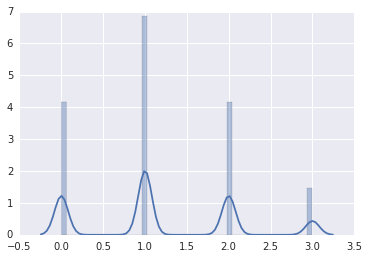

In [30]:
print(current_age)
sns.distplot(age);
# current_age

In [31]:
pickle_file = 'imdb-age-gender.pkl'

try:
    f = open(os.getcwd()+"/pkl_folder/"+pickle_file, 'wb')
    save = {
    'age': age,
    'gender': gender,
    'imgs': imgs
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Since some photos are colored and some are gray scale, while the sizes are not consistent. Moreover, processing file in RBG format is too big, when attemp to save objects to pickle file, 60000 file is equivalent to 11GB. So we gonna resize image to 128x128, convert to grayscale.

Also due to limit of resources and time, I only pick first ```100000``` images to train.

In [6]:
# Convert images path to images.

# only take a subset of dataset: first 10000 imgs
# dataset = np.ndarray(shape=(100000, img_size, img_size, img_depth), dtype=np.float32)

if os.path.exists(os.getcwd()+"/pkl_folder/imdb_data_train.pkl") and os.path.exists(
    os.getcwd()+"/pkl_folder/imdb_data_valid.pkl") and os.path.exists(
    os.getcwd()+"/pkl_folder/imdb_data_test.pkl"):
    print("Dataset already present - Skip convert images to images.")
else:
    print("Converting images path to images.")
    real_imgs = []
    tmp = []
    for i, img_path in enumerate(imgs):
        if i==100000:
            break
        tmp = np.asarray(spm.imresize(spm.imread(img_path, flatten=1), (128, 128)), dtype=np.float32)
        real_imgs.append(tmp)

    print("Original size: {0} - Preprocess size: {1}".format(len(raw_sface), len(real_imgs)))
    
#     print("Converting images path to images.")
#     for i, img_path in enumerate(imgs):
#         if i == 100000:
#             break
#         image_data = resize(((ndimage.imread(img_path).astype(float) - img_depth / 2) / img_depth), 
#                             (img_size, img_size, img_depth), mode='reflect')
#         dataset[i, :, :, :] = image_data

#     print("Original size: {0} - Preprocess size: {1}".format(len(raw_sface), len(dataset)))

Dataset already present - Skip convert images to images.


Dump 3 datasets to pickles.

In [7]:
def dump_data(file_path, slice_from, slice_to):
    data = {'image_inputs': np.array(real_imgs[slice_from:slice_to]),
            'age_labels': np.array(age[slice_from:slice_to]),
            'gender_labels': np.array(gender[slice_from:slice_to])
            }
    print("Dataset dump size: {}".format(len(data['image_inputs'])))
    with open(file_path,'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    print("Dumped to {}".format(file_path))

def create_pickle(force=False):
    data_train_path = os.getcwd()+"/pkl_folder/imdb_data_train.pkl"
    data_valid_path = os.getcwd()+"/pkl_folder/imdb_data_valid.pkl"
    data_test_path = os.getcwd()+"/pkl_folder/imdb_data_test.pkl"
    if os.path.exists(data_train_path) and os.path.exists(
        data_valid_path) and os.path.exists(
        data_test_path) and not force:
        # You may override by setting force=True.
        print("Dataset already present - Skip pickling.")
        
    else:
        dump_data(data_train_path, 0, 60000)
        dump_data(data_valid_path, 60000, 80000)
        dump_data(data_test_path, 80000, 1000000)

    return data_train_path, data_valid_path, data_test_path

data_train_path, data_valid_path, data_test_path = create_pickle()

Dataset already present - Skip pickling.


As we are using only a subset of the data, and also using a self-constructed model that has a much smaller capacity, thus we need to take steps to adjust accordingly.

The original paper uses 101101 age classes, which was appropriate for the their data set size and learning architecture. As we are only using a small subset of the data and a very simple model, the number of classes was set to 4:
* Young    (30yrs < age)
* Middle   (30 <= age <45)
* Old      (45 <= age < 60)
* Very Old (60 <= age)

In [8]:
def convert_label(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            data_train = pickle.load(f)
            labels = np.ndarray((len(data_train['image_inputs']), num_classes), dtype=np.int32)
            dataset = np.ndarray((len(data_train['image_inputs']), img_size, img_size, img_depth), dtype=np.float32)
            # let's shuffle to have random dataset
            np.random.shuffle(dataset)
            dataset = data_train['image_inputs']
            for i, age_label in enumerate(data_train['age_labels']):
                if i==len(data_train['image_inputs']):
                    break
                if age_label < 30:
                    age = 0
                elif age_label <= 45:
                    age = 1
                elif age_label < 60:
                    age = 2
                elif age_label >= 60:
                    age = 3
                else:
                    continue
                labels[i,:] = np.array([age, data_train['gender_labels'][i]])
            return dataset, labels
            
    except Exception as e:
        print('Unable to process data from', pickle_file, ':', e)
        raise

train_dataset, train_labels = convert_label(data_train_path)
valid_dataset, valid_labels = convert_label(data_valid_path)
test_dataset, test_labels = convert_label(data_test_path)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (60000, 128, 128) (60000, 2)
Validation: (20000, 128, 128) (20000, 2)
Testing: (20000, 128, 128) (20000, 2)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Reformat into a TensorFlow-friendly shape:
* convolutions need the image data formatted as a cube (width by height by channels)
* labels as float 1-hot encodings.

In [10]:
num_channels = img_depth # = 1 (Grayscale)

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, img_size, img_size, num_channels)).astype(np.float32)
    one_hot_labels = np.ndarray((len(labels), 2, 4), dtype=np.float32)
    for i, label in enumerate(labels):
        one_hot_age = (np.arange(4)==label[0]).astype(np.float32)
        one_hot_gender = (np.arange(4)==label[1]).astype(np.float32)
        one_hot_labels[i,:,:] = np.array([one_hot_age, one_hot_gender])
#     labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, one_hot_labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (60000, 128, 128, 1) (60000, 2, 4)
Validation set (20000, 128, 128, 1) (20000, 2, 4)
Test set (20000, 128, 128, 1) (20000, 2, 4)


Save to final pickle file.

In [11]:
pickle_file = 'imdb.pkl'

try:
    f = open(os.getcwd()+"/pkl_folder/"+pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(os.getcwd()+"/pkl_folder/"+pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 6556800496
